# Tugas Besar Sains Data Rekayasa

oleh K16:
</br>Kemal Rizky Fadhlurrohman 10219113
</br>Imam Rakhmadi 13320046
</br>Deedat Fatahillah 13320072



## 0.Config

Kode berikut digunakan untuk melakukan training data dan object detection ayam serta memprediksi rata-rata berat ayam.

Untuk menjalankan kode, download file pada tautan berikut:

https://drive.google.com/drive/folders/1bDzEsL0KTKuolXG0CPv5WYhnZDwtm1BZ?usp=share_link

lalu upload ke Google Drive (akun yang sama yang digunakan untuk menjalankan Google Colab) pada direktori:
My Drive/Colab Notebooks/Tubes_SDR/COCO

Jalankan kode pada blok Install Dependencies. Kemudian, pilih restart runtime. Selanjutnya, jalankan kode dibawahnya secara berurutan

### Install Dependencies

In [ ]:
!pip install -U torch torchvision
!pip install git+https://github.com/facebookresearch/fvcore.git
!git clone https://github.com/facebookresearch/detectron2 detectron2_repo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |██████████████████████████████  | 834.1 MB 889 kB/s eta 0:01:00tcmalloc: large alloc 1147494400 bytes == 0x65554000 @  0x7f16ce779615 0x5d6f4c 0x51edd1 0x51ef5b 0x4f750a 0x4997a2 0x4fd8b5 0x4997c7 0x4fd8b5 0x49abe4 0x4f5fe9 0x55e146 0x4f5fe9 0x55e146 0x4f5fe9 0x55e146 0x5d8868 0x5da092 0x587116 0x5d8d8c 0x55dc1e 0x55cd91 0x5d8941 0x49abe4 0x55cd91 0x5d8941 0x4990ca 0x5d8868 0x4997a2 0x4fd8b5 0x49abe4
     |████████████████████████████████| 887.4 MB 1.7 kB/s 
     |████████████████████████████████| 24.2 MB 1.3 MB/s 
     |████████████████████████████████| 21.0 MB 1.4 MB/s 
     |████████████████████████████████| 849 kB 70.9 MB/s 
     |████████████████████████████████| 317.1 MB 31 kB/s 
     |████████████████████████████████| 557.1 MB 12 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.13.0+cu116
    Uninstalling torch-1.13.0+cu116:
      Successfully unin

In [ ]:
!pip install -e detectron2_repo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/detectron2_repo
     |████████████████████████████████| 79 kB 9.9 MB/s 
     |████████████████████████████████| 154 kB 73.8 MB/s 
     |████████████████████████████████| 1.5 MB 52.5 MB/s 
     |████████████████████████████████| 549 kB 70.3 MB/s 
     |████████████████████████████████| 117 kB 78.2 MB/s 
     |████████████████████████████████| 96 kB 7.0 MB/s 
     |████████████████████████████████| 182 kB 76.4 MB/s 
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144575 sha256=1e02011172a393a1c51137feca6072e5acb71f62025494d1e8c10d3a2b28ab45
  Stored in directory: /root/.cache/pip/wheels/b1/a3/c2/6df046c09459b73cc9bb6c4401b0be6c47048baf9a1617c485
Successfully built antlr4-python3-runtime
  Attempting uninstall: iopath
    Found existing installation: iopath 0.1.10
    Uninstalling iopath-0.1.10:
      Successfu

### Drive setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pwd

/content


### Init

In [ ]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("broilercv", {}, "drive/My Drive/Colab Notebooks/Tubes_SDR/COCO/train.json", "drive/My Drive/Colab Notebooks/Tubes_SDR/COCO/image")
register_coco_instances("broilercv-val", {}, "drive/My Drive/Colab Notebooks/Tubes_SDR/COCO/val.json", "drive/My Drive/Colab Notebooks/Tubes_SDR/COCO/image")

In [ ]:
import random
import cv2


from google.colab.patches import cv2_imshow
from detectron2.data import DatasetCatalog
from detectron2.data import MetadataCatalog
from detectron2.utils.visualizer import Visualizer

dataset_dicts = DatasetCatalog.get("broilercv")
broilercv_metadata = MetadataCatalog.get("broilercv")

broilercv_val_metadata = MetadataCatalog.get("broilercv")
dataset_val_dicts = DatasetCatalog.get("broilercv-val")


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



### Show the Annotations

In [ ]:
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    cv2_imshow(img)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    print(d['file_name'])
    visualizer = Visualizer(img[:, :, ::-1], metadata=broilercv_val_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

Output hidden; open in https://colab.research.google.com to view.

## 1.Train

##### Training Config

In [ ]:
from detectron2.engine.hooks import HookBase
from detectron2.evaluation import inference_context
from detectron2.utils.logger import log_every_n_seconds
from detectron2.data import DatasetMapper, build_detection_test_loader
import detectron2.utils.comm as comm
import torch
import time
import datetime
import logging
import numpy as np

class LossEvalHook(HookBase):
    def __init__(self, eval_period, model, data_loader):
        self._model = model
        self._period = eval_period
        self._data_loader = data_loader
    
    def _do_loss_eval(self):
        # Copying inference_on_dataset from evaluator.py
        total = len(self._data_loader)
        num_warmup = min(5, total - 1)
            
        start_time = time.perf_counter()
        total_compute_time = 0
        losses = []
        for idx, inputs in enumerate(self._data_loader):            
            if idx == num_warmup:
                start_time = time.perf_counter()
                total_compute_time = 0
            start_compute_time = time.perf_counter()
            if torch.cuda.is_available():
                torch.cuda.synchronize()
            total_compute_time += time.perf_counter() - start_compute_time
            iters_after_start = idx + 1 - num_warmup * int(idx >= num_warmup)
            seconds_per_img = total_compute_time / iters_after_start
            if idx >= num_warmup * 2 or seconds_per_img > 5:
                total_seconds_per_img = (time.perf_counter() - start_time) / iters_after_start
                eta = datetime.timedelta(seconds=int(total_seconds_per_img * (total - idx - 1)))
                log_every_n_seconds(
                    logging.INFO,
                    "Loss on Validation  done {}/{}. {:.4f} s / img. ETA={}".format(
                        idx + 1, total, seconds_per_img, str(eta)
                    ),
                    n=5,
                )
            loss_batch = self._get_loss(inputs)
            losses.append(loss_batch)
        mean_loss = np.mean(losses)
        self.trainer.storage.put_scalar('validation_loss', mean_loss)
        comm.synchronize()

        return losses
            
    def _get_loss(self, data):
        # How loss is calculated on train_loop 
        metrics_dict = self._model(data)
        metrics_dict = {
            k: v.detach().cpu().item() if isinstance(v, torch.Tensor) else float(v)
            for k, v in metrics_dict.items()
        }
        total_losses_reduced = sum(loss for loss in metrics_dict.values())
        return total_losses_reduced
        
        
    def after_step(self):
        next_iter = self.trainer.iter + 1
        is_final = next_iter == self.trainer.max_iter
        if is_final or (self._period > 0 and next_iter % self._period == 0):
            self._do_loss_eval()
        self.trainer.storage.put_scalars(timetest=12)

##### Trainer

In [ ]:
from detectron2.engine import DefaultTrainer

from detectron2.evaluation import (
    COCOEvaluator
)

class MyTrainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
        return COCOEvaluator(dataset_name, cfg, True, output_folder)
                     
    def build_hooks(self):
        hooks = super().build_hooks()
        hooks.insert(-1,LossEvalHook(
            cfg.TEST.EVAL_PERIOD,
            self.model,
            build_detection_test_loader(
                self.cfg,
                self.cfg.DATASETS.TEST[0],
                DatasetMapper(self.cfg,True)
            )
        ))
        return hooks

In [ ]:
from detectron2.config import get_cfg
from detectron2 import model_zoo
import os

cfg = get_cfg()
cfg.merge_from_file("./detectron2_repo/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")

cfg.DATASETS.TRAIN = ("broilercv",)
cfg.DATASETS.TEST = ("broilercv-val",)
cfg.TEST.EVAL_PERIOD = 20
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.MODEL.MASK_ON = True
cfg.SOLVER.IMS_PER_BATCH = 2  # This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 600    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # The "RoIHead batch size". 128 is faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.


In [ ]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = MyTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[12/23 13:20:53 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f10217.pkl: 178MB [00:15, 11.6MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


[12/23 13:21:16 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.8/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


WARNING [12/23 13:21:41 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[12/23 13:21:41 d2.data.datasets.coco]: Loaded 17 images in COCO format from drive/My Drive/Colab Notebooks/Tubes_SDR/COCO/val.json
[12/23 13:21:41 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[12/23 13:21:41 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common.NumpySerializedList'>
[12/23 13:21:41 d2.data.common]: Serializing 17 elements to byte tensors and concatenating them all ...
[12/23 13:21:41 d2.data.common]: Serialized dataset takes 0.10 MiB
WARNING [12/23 13:21:41 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[12/23 13:21:41 d2.evaluation.evaluator]: Start inference on 17 batches
[12/23 13:21:51 d2.ev

##  2.Image Segmentation: Prediction

#### a.Default Predictor (Testing Menggunakan Data K16)

[12/23 13:34:02 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...
WARNING [12/23 13:34:02 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[12/23 13:34:02 d2.data.datasets.coco]: Loaded 17 images in COCO format from drive/My Drive/Colab Notebooks/Tubes_SDR/COCO/val.json
drive/My Drive/Colab Notebooks/Tubes_SDR/COCO/image/Data1_(10).png


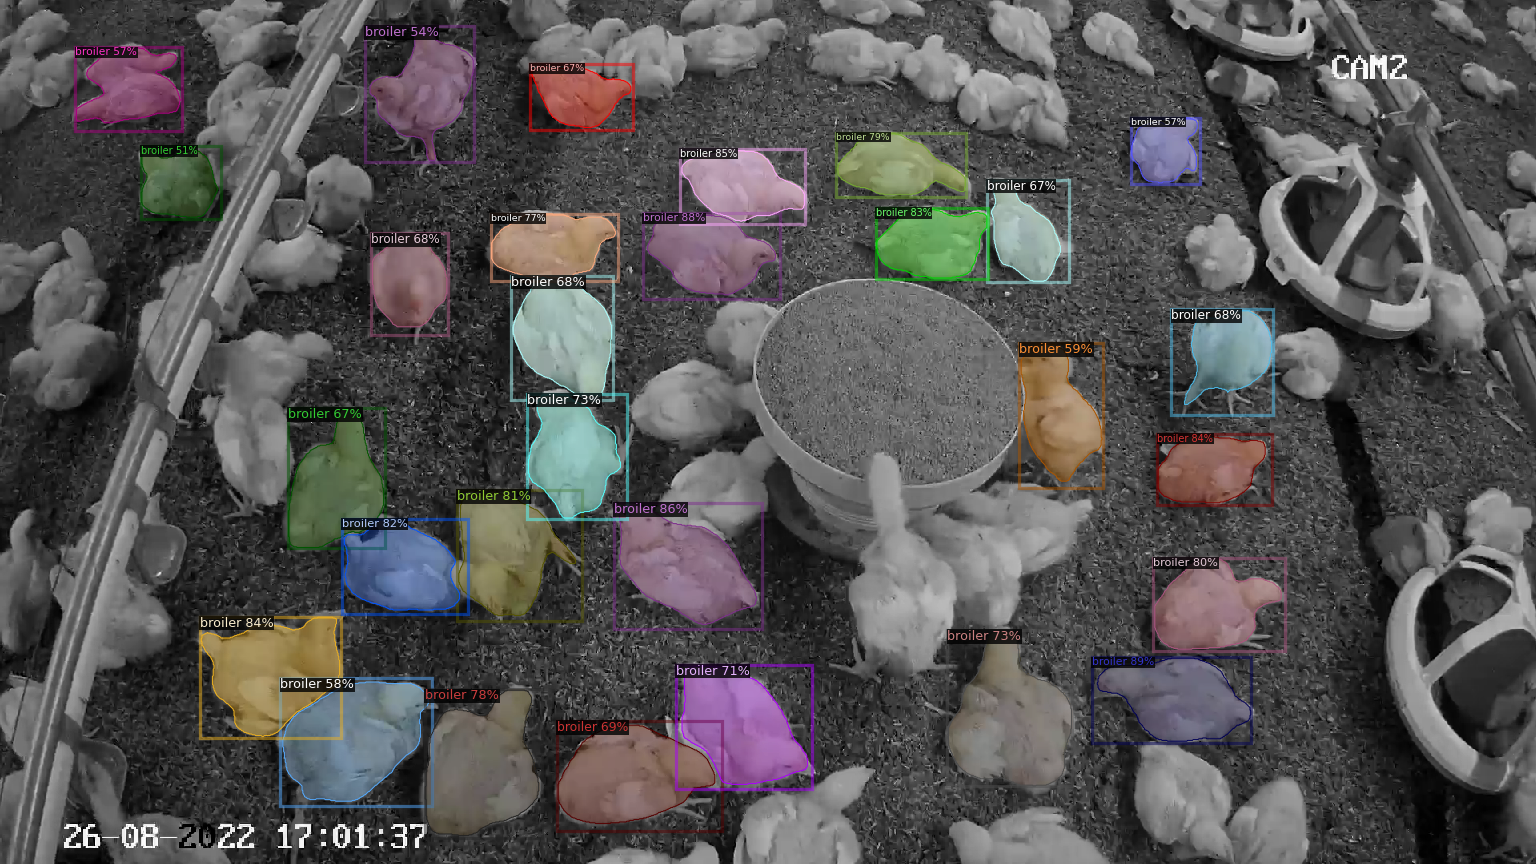

Detected broiler: 29
Average broiler area: 12091


In [ ]:
from detectron2.engine import DefaultPredictor
import os
import numpy as np
import torch

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
cfg.DATASETS.TEST = ("broiliercv-val", )
predictor = DefaultPredictor(cfg)

  
from detectron2.utils.visualizer import ColorMode
broilercv_val_metadata = MetadataCatalog.get("broilercv-val")
dataset_val_dicts = DatasetCatalog.get("broilercv-val")

for d in random.sample(dataset_val_dicts, 1):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=broilercv_val_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    print(d['file_name'])
    cv2_imshow(v.get_image()[:, :, ::-1])

    
    # calculate mean broiler area
    masks = outputs['instances'].pred_masks
    print("Detected broiler:", masks.shape[0])
    broilerAreaTensor = torch.sum(torch.flatten(masks, start_dim=1),dim=1)
    broilerArea = broilerAreaTensor.tolist()
    meanBroilerArea = round(np.mean(broilerArea))
    print("Average broiler area:", meanBroilerArea)

#### b. Prediksi terhadap Data K17

drive/My Drive/Colab Notebooks/Tubes_SDR/COCO/test/Data11/Data11_(5).png


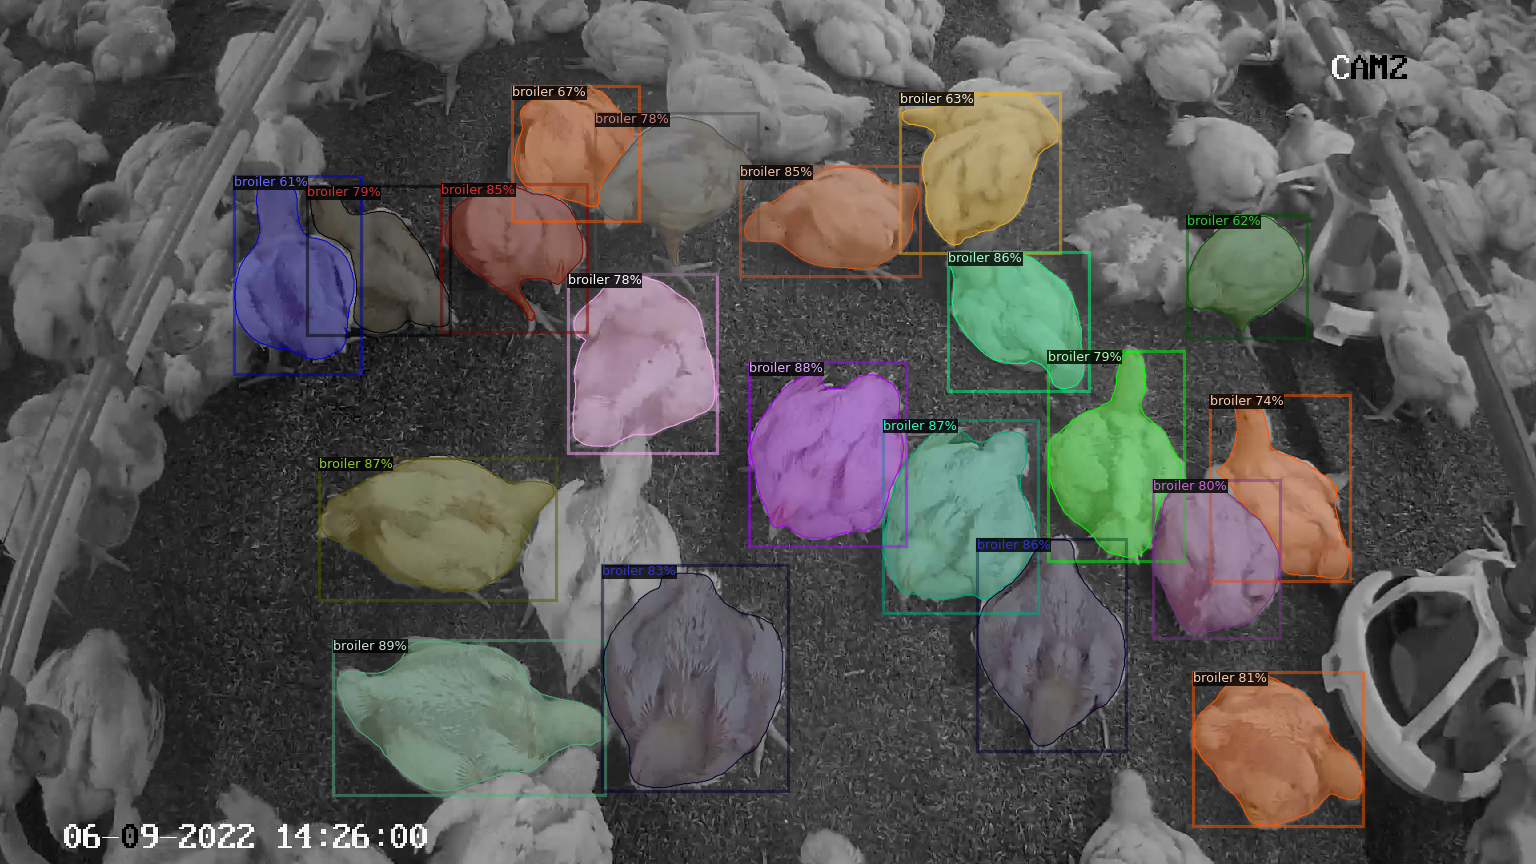

Detected broiler: 20
Average broiler area: 25139


In [ ]:
im = cv2.imread("drive/My Drive/Colab Notebooks/Tubes_SDR/COCO/test/Data11/Data11_(5).png")
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1],
                metadata=broilercv_val_metadata, 
                scale=0.8, 
                instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
print("drive/My Drive/Colab Notebooks/Tubes_SDR/COCO/test/Data11/Data11_(5).png")
cv2_imshow(v.get_image()[:, :, ::-1])


# calculate mean broiler area
masks = outputs['instances'].pred_masks
print("Detected broiler:", masks.shape[0])
broilerAreaTensor = torch.sum(torch.flatten(masks, start_dim=1),dim=1)
broilerArea = broilerAreaTensor.tolist()
meanBroilerArea = round(np.mean(broilerArea))
print("Average broiler area:", meanBroilerArea)

##### Data 1

In [ ]:
path = "drive/My Drive/Colab Notebooks/Tubes_SDR/COCO/test/Data1"
files = os.listdir(path)

data1_avgBroilerArea_perImage = []

for file in files:
    filename = os.path.join(path,file)
    im = cv2.imread(filename)
    outputs = predictor(im)

    # calculate mean broiler area
    masks = outputs['instances'].pred_masks
    broilerAreaTensor = torch.sum(torch.flatten(masks, start_dim=1),dim=1)
    broilerArea = broilerAreaTensor.tolist()
    meanBroilerArea = round(np.mean(broilerArea))
    data1_avgBroilerArea_perImage.append(meanBroilerArea)

data1_avgBroilerArea = round(np.mean(data1_avgBroilerArea_perImage))

print("Average pixel area for detected broiler in data 1:", data1_avgBroilerArea)
    

Average pixel area for detected broiler in data 1: 11709


##### Data 2

In [ ]:
path = "drive/My Drive/Colab Notebooks/Tubes_SDR/COCO/test/Data2"
files = os.listdir(path)

data2_avgBroilerArea_perImage = []

for file in files:
    filename = os.path.join(path,file)
    im = cv2.imread(filename)
    outputs = predictor(im)

    # calculate mean broiler area
    masks = outputs['instances'].pred_masks
    broilerAreaTensor = torch.sum(torch.flatten(masks, start_dim=1),dim=1)
    broilerArea = broilerAreaTensor.tolist()
    meanBroilerArea = round(np.mean(broilerArea))
    data2_avgBroilerArea_perImage.append(meanBroilerArea)

data2_avgBroilerArea = round(np.mean(data2_avgBroilerArea_perImage))

print("Average pixel area for detected broiler in data 2:",data2_avgBroilerArea)
    

Average pixel area for detected broiler in data 2: 12384


##### Data 3

In [ ]:
path = "drive/My Drive/Colab Notebooks/Tubes_SDR/COCO/test/Data3"
files = os.listdir(path)

data3_avgBroilerArea_perImage = []

for file in files:
    filename = os.path.join(path,file)
    im = cv2.imread(filename)
    outputs = predictor(im)

    # calculate mean broiler area
    masks = outputs['instances'].pred_masks
    broilerAreaTensor = torch.sum(torch.flatten(masks, start_dim=1),dim=1)
    broilerArea = broilerAreaTensor.tolist()
    meanBroilerArea = round(np.mean(broilerArea))
    data3_avgBroilerArea_perImage.append(meanBroilerArea)

data3_avgBroilerArea = round(np.mean(data3_avgBroilerArea_perImage))

print("Average pixel area for detected broiler in data 3:",data3_avgBroilerArea)
    

Average pixel area for detected broiler in data 3: 13049


##### Data 4

In [ ]:
path = "drive/My Drive/Colab Notebooks/Tubes_SDR/COCO/test/Data4"
files = os.listdir(path)

data4_avgBroilerArea_perImage = []

for file in files:
    filename = os.path.join(path,file)
    im = cv2.imread(filename)
    outputs = predictor(im)

    # calculate mean broiler area
    masks = outputs['instances'].pred_masks
    broilerAreaTensor = torch.sum(torch.flatten(masks, start_dim=1),dim=1)
    broilerArea = broilerAreaTensor.tolist()
    meanBroilerArea = round(np.mean(broilerArea))
    data4_avgBroilerArea_perImage.append(meanBroilerArea)

data4_avgBroilerArea = round(np.mean(data4_avgBroilerArea_perImage))

print("Average pixel area for detected broiler in data 4:", data4_avgBroilerArea)
    

Average pixel area for detected broiler in data 4: 12930


##### Data 5

In [ ]:
path = "drive/My Drive/Colab Notebooks/Tubes_SDR/COCO/test/Data5"
files = os.listdir(path)

data5_avgBroilerArea_perImage = []

for file in files:
    filename = os.path.join(path,file)
    im = cv2.imread(filename)
    outputs = predictor(im)

    # calculate mean broiler area
    masks = outputs['instances'].pred_masks
    broilerAreaTensor = torch.sum(torch.flatten(masks, start_dim=1),dim=1)
    broilerArea = broilerAreaTensor.tolist()
    meanBroilerArea = round(np.mean(broilerArea))
    data5_avgBroilerArea_perImage.append(meanBroilerArea)

data5_avgBroilerArea = round(np.mean(data5_avgBroilerArea_perImage))

print("Average pixel area for detected broiler in data 5:",data5_avgBroilerArea)
    

Average pixel area for detected broiler in data 5: 16496


##### Data 6

In [ ]:
path = "drive/My Drive/Colab Notebooks/Tubes_SDR/COCO/test/Data6"
files = os.listdir(path)

data6_avgBroilerArea_perImage = []

for file in files:
    filename = os.path.join(path,file)
    im = cv2.imread(filename)
    outputs = predictor(im)

    # calculate mean broiler area
    masks = outputs['instances'].pred_masks
    broilerAreaTensor = torch.sum(torch.flatten(masks, start_dim=1),dim=1)
    broilerArea = broilerAreaTensor.tolist()
    meanBroilerArea = round(np.mean(broilerArea))
    data6_avgBroilerArea_perImage.append(meanBroilerArea)

data6_avgBroilerArea = round(np.mean(data6_avgBroilerArea_perImage))

print("Average pixel area for detected broiler in data 6:",data6_avgBroilerArea)
    

Average pixel area for detected broiler in data 6: 17586


##### Data 7

In [ ]:
path = "drive/My Drive/Colab Notebooks/Tubes_SDR/COCO/test/Data7"
files = os.listdir(path)

data7_avgBroilerArea_perImage = []

for file in files:
    filename = os.path.join(path,file)
    im = cv2.imread(filename)
    outputs = predictor(im)

    # calculate mean broiler area
    masks = outputs['instances'].pred_masks
    broilerAreaTensor = torch.sum(torch.flatten(masks, start_dim=1),dim=1)
    broilerArea = broilerAreaTensor.tolist()
    meanBroilerArea = round(np.mean(broilerArea))
    data7_avgBroilerArea_perImage.append(meanBroilerArea)

data7_avgBroilerArea = round(np.mean(data7_avgBroilerArea_perImage))

print("Average pixel area for detected broiler in data 7:",data7_avgBroilerArea)
    

Average pixel area for detected broiler in data 7: 18954


##### Data 8

In [ ]:
path = "drive/My Drive/Colab Notebooks/Tubes_SDR/COCO/test/Data8"
files = os.listdir(path)

data8_avgBroilerArea_perImage = []

for file in files:
    filename = os.path.join(path,file)
    im = cv2.imread(filename)
    outputs = predictor(im)

    # calculate mean broiler area
    masks = outputs['instances'].pred_masks
    broilerAreaTensor = torch.sum(torch.flatten(masks, start_dim=1),dim=1)
    broilerArea = broilerAreaTensor.tolist()
    meanBroilerArea = round(np.mean(broilerArea))
    data8_avgBroilerArea_perImage.append(meanBroilerArea)

data8_avgBroilerArea = round(np.mean(data8_avgBroilerArea_perImage))

print("Average pixel area for detected broiler in data 8:",data8_avgBroilerArea)
    

Average pixel area for detected broiler in data 8: 21031


##### Data 9 

In [ ]:
path = "drive/My Drive/Colab Notebooks/Tubes_SDR/COCO/test/Data9"
files = os.listdir(path)

data9_avgBroilerArea_perImage = []

for file in files:
    filename = os.path.join(path,file)
    im = cv2.imread(filename)
    outputs = predictor(im)

    # calculate mean broiler area
    masks = outputs['instances'].pred_masks
    broilerAreaTensor = torch.sum(torch.flatten(masks, start_dim=1),dim=1)
    broilerArea = broilerAreaTensor.tolist()
    meanBroilerArea = round(np.mean(broilerArea))
    data9_avgBroilerArea_perImage.append(meanBroilerArea)

data9_avgBroilerArea = round(np.mean(data9_avgBroilerArea_perImage))

print("Average pixel area for detected broiler in data 9:",data9_avgBroilerArea)
    

Average pixel area for detected broiler in data 9: 21234


##### Data 10

In [ ]:
path = "drive/My Drive/Colab Notebooks/Tubes_SDR/COCO/test/Data10"
files = os.listdir(path)

data10_avgBroilerArea_perImage = []

for file in files:
    filename = os.path.join(path,file)
    im = cv2.imread(filename)
    outputs = predictor(im)

    # calculate mean broiler area
    masks = outputs['instances'].pred_masks
    broilerAreaTensor = torch.sum(torch.flatten(masks, start_dim=1),dim=1)
    broilerArea = broilerAreaTensor.tolist()
    meanBroilerArea = round(np.mean(broilerArea))
    data10_avgBroilerArea_perImage.append(meanBroilerArea)

data10_avgBroilerArea = round(np.mean(data10_avgBroilerArea_perImage))

print("Average pixel area for detected broiler in data 10:",data10_avgBroilerArea)
    

Average pixel area for detected broiler in data 10: 23892


##### Data 11

In [ ]:
path = "drive/My Drive/Colab Notebooks/Tubes_SDR/COCO/test/Data11"
files = os.listdir(path)

data11_avgBroilerArea_perImage = []

for file in files:
    filename = os.path.join(path,file)
    im = cv2.imread(filename)
    outputs = predictor(im)

    # calculate mean broiler area
    masks = outputs['instances'].pred_masks
    broilerAreaTensor = torch.sum(torch.flatten(masks, start_dim=1),dim=1)
    broilerArea = broilerAreaTensor.tolist()
    meanBroilerArea = round(np.mean(broilerArea))
    data11_avgBroilerArea_perImage.append(meanBroilerArea)

data11_avgBroilerArea = round(np.mean(data11_avgBroilerArea_perImage))

print("Average pixel area for detected broiler in data 11:",data11_avgBroilerArea)
    

Average pixel area for detected broiler in data 11: 23916


##### Data 12

In [ ]:
path = "drive/My Drive/Colab Notebooks/Tubes_SDR/COCO/test/Data12"
files = os.listdir(path)

data12_avgBroilerArea_perImage = []

for file in files:
    filename = os.path.join(path,file)
    im = cv2.imread(filename)
    outputs = predictor(im)

    # calculate mean broiler area
    masks = outputs['instances'].pred_masks
    broilerAreaTensor = torch.sum(torch.flatten(masks, start_dim=1),dim=1)
    broilerArea = broilerAreaTensor.tolist()
    meanBroilerArea = round(np.mean(broilerArea))
    data12_avgBroilerArea_perImage.append(meanBroilerArea)

data12_avgBroilerArea = round(np.mean(data12_avgBroilerArea_perImage))

print("Average pixel area for detected broiler in data 12:",data12_avgBroilerArea)
    

Average pixel area for detected broiler in data 12: 25551


##### Data 13

In [ ]:
path = "drive/My Drive/Colab Notebooks/Tubes_SDR/COCO/test/Data13"
files = os.listdir(path)

data13_avgBroilerArea_perImage = []

for file in files:
    filename = os.path.join(path,file)
    im = cv2.imread(filename)
    outputs = predictor(im)

    # calculate mean broiler area
    masks = outputs['instances'].pred_masks
    broilerAreaTensor = torch.sum(torch.flatten(masks, start_dim=1),dim=1)
    broilerArea = broilerAreaTensor.tolist()
    meanBroilerArea = round(np.mean(broilerArea))
    data13_avgBroilerArea_perImage.append(meanBroilerArea)

data13_avgBroilerArea = round(np.mean(data13_avgBroilerArea_perImage))

print("Average pixel area for detected broiler in data 13:",data13_avgBroilerArea)
    

Average pixel area for detected broiler in data 13: 26853


## 3.Weight Prediction

#### Build Model using Polynomial Regression

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from sklearn.model_selection import KFold
import pandas as pd

In [ ]:
# function to generate model
def fit_poly(x, y, Npoly):
    Ndata = len(x)
    X = np.zeros((Ndata,Npoly+1))
    X[:,0] = 1.0
    for i in range (1,Npoly+1):
        X[:,i] = np.power(x,i)
    XtX = X.transpose() @ X
    XtXinv = np.linalg.inv(XtX)
    w = XtXinv @ X.transpose() @ y
    return X, w

# function to evaluate model
def predict_poly(w, x_eval):
    Npoly = w.shape[0] - 1
    Ndata_eval = x_eval.shape[0]
    X_eval = np.zeros((Ndata_eval,Npoly+1))
    X_eval[:,0] = 1.0
    for j in range(1,Npoly+1):
        X_eval[:,j] = np.power(x_eval, j)
    y_eval = X_eval @ w
    return y_eval

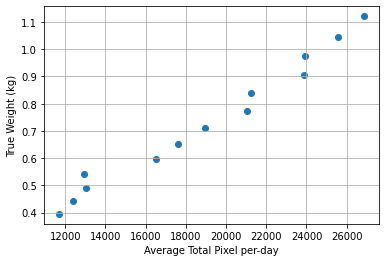

In [ ]:
t = [0.3952, 0.4414, 0.4902, 0.5416, 0.5956, 0.6522, 0.7114, 0.7732, 0.8376, 0.9046, 0.9742, 1.0464, 1.1212] # hasil interpolasi rata-rata berat ayam hari ke-11 s.d. 23
x = [data1_avgBroilerArea, data2_avgBroilerArea, data3_avgBroilerArea, data4_avgBroilerArea,
     data5_avgBroilerArea, data6_avgBroilerArea, data7_avgBroilerArea, data8_avgBroilerArea,
     data9_avgBroilerArea, data10_avgBroilerArea, data11_avgBroilerArea, data12_avgBroilerArea, data13_avgBroilerArea]  # hasil perhitungan rata-rata luas ayam ke-11 s.d. 23
t = np.array(t)
x = np.array(x)

plt.scatter(x, t)
plt.grid(True)
plt.xlabel('Average Total Pixel per-day')
plt.ylabel('True Weight (kg)')
plt.show()

In [ ]:
NptsPlot = 200
x_eval = np.linspace(np.amin(x), np.amax(x), NptsPlot)

Y_eval = []
max_order = 3

model_weight = np.zeros((max_order, max_order+1))

for Npoly in range(1,max_order+1):
    X, w = fit_poly(x, t, Npoly)
    Y_eval.append(predict_poly(w, x_eval))

    # store the coefficient
    for i in range(len(w)):
        model_weight[Npoly-1,i] = w[i]

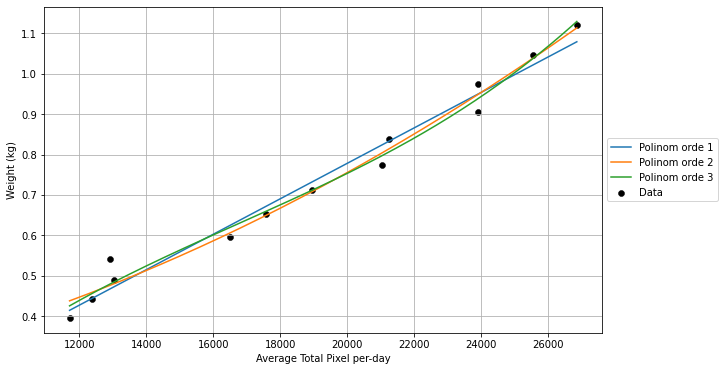

In [ ]:
# plot model
plt.figure(figsize=(10, 6))
plt.scatter(x, t, color='black', label='Data', linewidths=0.5)
for i in range(0,max_order):
    plt.plot(x_eval, Y_eval[i], label='Polinom orde '+str(i+1))
plt.grid(True)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Average Total Pixel per-day')
plt.ylabel('Weight (kg)')
plt.show()

#### Evaluate Model using KFold Cross Validation

Orde Polinom = 1    loss = 0.0015865360500669783
Orde Polinom = 2    loss = 0.0008107800321564109
Orde Polinom = 3    loss = 0.0010817232285596338

Best fitted model: Polinom orde 2


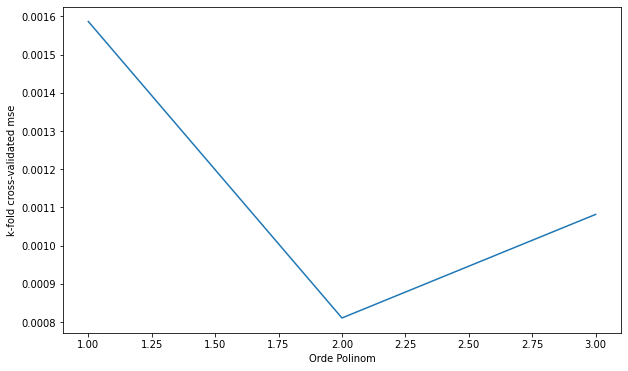

In [ ]:
# model evaluation
k = 10
kf = KFold(n_splits=k, shuffle=True, random_state=10219113)

degrees = range(1, max_order+1)

test_mse = []

for train_index, test_index in kf.split(x, t):
    split_mse = []
    for deg in degrees:
        X, w = fit_poly(x[train_index], t[train_index], deg)
        y_eval = predict_poly(w, x[test_index])
        
        mse = np.mean((t[test_index] - y_eval)**2)
        split_mse.append(mse)
    test_mse.append(split_mse)  
test_mse = np.mean(test_mse, axis=0)

for deg, mse in zip(degrees, test_mse):
    print('Orde Polinom =', deg, "   loss =", mse)

print()
print("Best fitted model: Polinom orde", np.argmin(test_mse)+1)

plt.figure(figsize=(10, 6))
plt.plot(degrees, test_mse)
plt.xlabel("Orde Polinom")
plt.ylabel("k-fold cross-validated mse")
plt.show()

Apabila koefisien dari model polinomial memenuhi persamaan berikut,
$$
W = w_0 + w_1 p  + w_2 p^2
$$

dengan W merupakan predicted weight(kg) dan p merupakan total pixel value

In [ ]:
print("Koefisien polinomial dari model")
df = pd.DataFrame(model_weight[1])
df.columns =['Koefisien Persamaan Polinom orde-2']
df.index = ['w0','w1','w2','w3']
display(df)

Koefisien polinomial dari model


Koefisien Persamaan Polinom orde-2
w0                        2.046994e-01
w1                        9.104621e-06
w2                        9.215140e-10
w3                        0.000000e+00

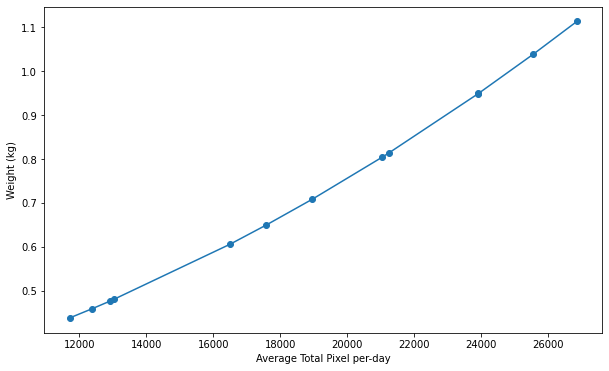

In [ ]:
predicted_weight = []

# model to predict weight
def weight_predict_model(x_):
  return model_weight[1][0] + model_weight[1][1]*x_ + model_weight[1][2]*x_**2


for i in range(len(x)):
    predicted_weight.append(weight_predict_model(x[i]))

plt.figure(figsize=(10, 6))
plt.plot(x, predicted_weight, '-o')
plt.xlabel('Average Total Pixel per-day')
plt.ylabel('Weight (kg)')
plt.show()

#### Prediction

drive/My Drive/Colab Notebooks/Tubes_SDR/COCO/test/Data11/Data11_(5).png


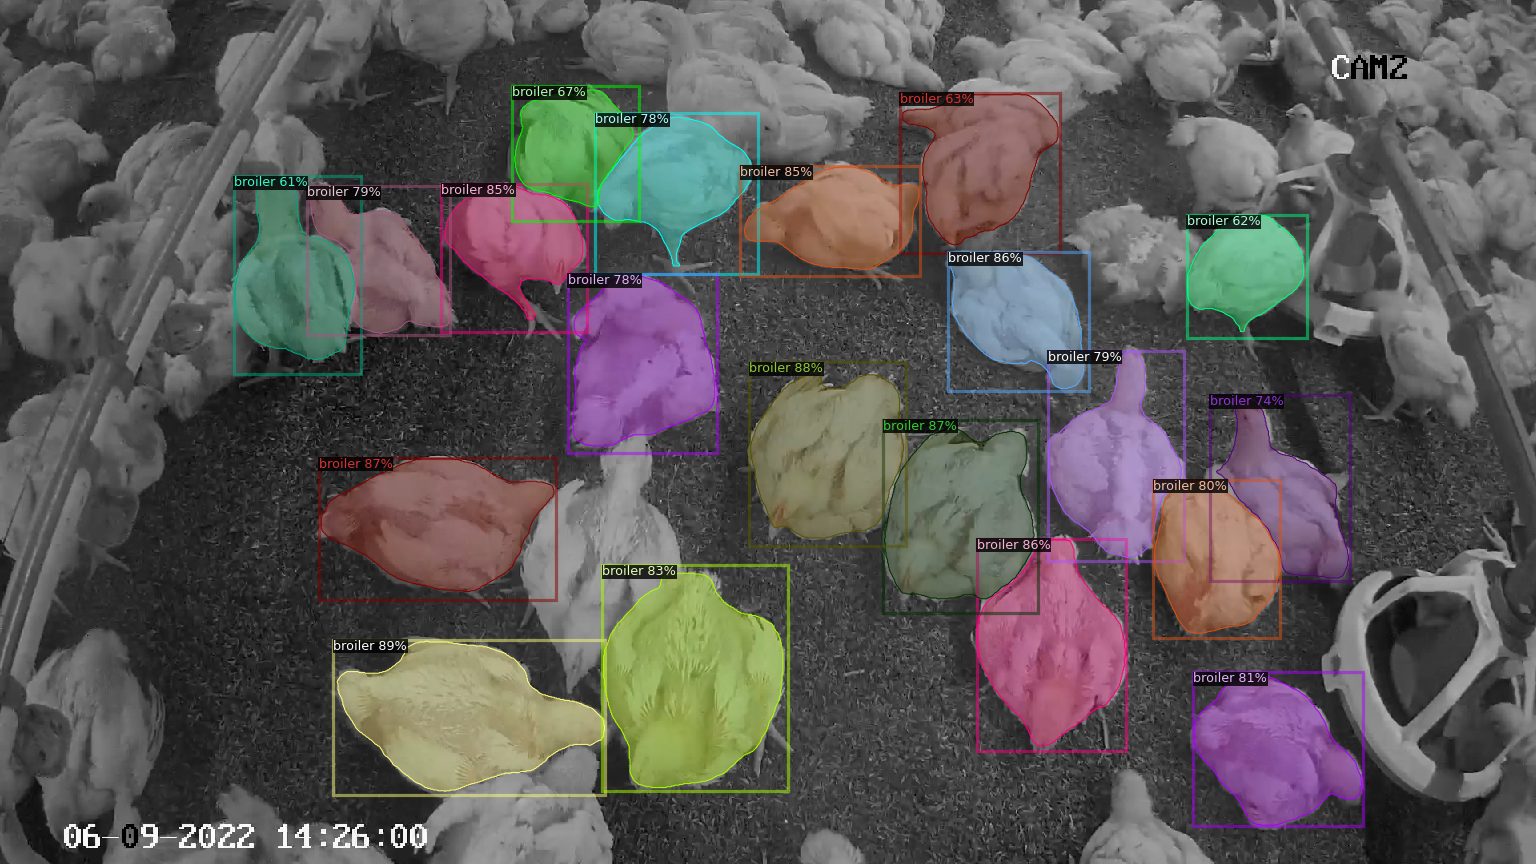

Detected broiler: 20
Average broiler area: 25139 pixel
Predicted average weight: 1.02 kg


In [ ]:
im = cv2.imread("drive/My Drive/Colab Notebooks/Tubes_SDR/COCO/test/Data11/Data11_(5).png")
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1],
                metadata=broilercv_val_metadata, 
                scale=0.8, 
                instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
print("drive/My Drive/Colab Notebooks/Tubes_SDR/COCO/test/Data11/Data11_(5).png")
cv2_imshow(v.get_image()[:, :, ::-1])


# calculate mean broiler area
masks = outputs['instances'].pred_masks
print("Detected broiler:", masks.shape[0])
broilerAreaTensor = torch.sum(torch.flatten(masks, start_dim=1),dim=1)
broilerArea = broilerAreaTensor.tolist()
meanBroilerArea = round(np.mean(broilerArea))
print("Average broiler area:", meanBroilerArea, "pixel")
avg_weight = weight_predict_model(meanBroilerArea)
print("Predicted average weight:", round(avg_weight,2), "kg")